In [36]:
import chipwhisperer as cw
import random
import csv
import os
import numpy as np

In [37]:
SCOPETYPE="OPENADC"
PLATFORM='CW308_STM32F3'
CRYPTO_TARGET='NONE'
VERSION='HARDWARE'
SS_VER = 'SS_VER_1_1'

In [39]:
from tqdm.notebook import trange
import chipwhisperer as cw
scope = cw.scope()
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 800

scope.default_setup()
target = cw.target(scope)

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 800                       to 5000                     
scope.adc.trig_count                     changed from 957366                    to 22409255                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 0                         to 29538459                 
scope.clock.adc_rate                     changed from 0.0                       to 29538459.0               
scope.clock.clkgen_

In [40]:
prog = cw.programmers.STM32FProgrammer
print( " Programming target ... " )
cw.program_target(scope,prog, "/home/tarun/chipwhisperer/jupyter/simpleserial_rsa-CW308_STM32F3.hex" )
print( " Programming done . " )

 Programming target ... 
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5063 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5063 bytes
 Programming done . 


In [41]:
# scope.clock.adc_src = "clkgen_x1"
# scope.adc.samples = 5000

In [64]:
RSA_N = 64507
NUM_TRACES = 300 # YOU decide how many traces you need !
OUT_CSV = "my_traces.csv "

In [65]:
random.seed(0xCAFEBABE)
rows = []

In [66]:
from tqdm.notebook import trange # Use trange for a progress bar!

print(f"Capturing {NUM_TRACES} traces...")

# --- CAPTURE LOOP ---
for i in trange(NUM_TRACES, desc='Capturing'):
    # [cite_start]Per RSA rules, ciphertext must be < N. [cite: 20]
    c_int = random.randint(0, RSA_N - 1)
    ct_bytes = c_int.to_bytes(2, 'big')

    scope.arm()
    target.simpleserial_write('p', ct_bytes)
    
    ret = scope.capture()
    if ret:
        print(f"Capture timed out for trace {i+1}")
        continue
        
    trace = scope.get_last_trace()
    
    # --- THIS IS THE MISSING PART ---
    # Combine the ciphertext (as an integer) and the trace data into one list
    row_data = [c_int] + list(trace)
    # Add this combined list as a new row
    rows.append(row_data)

print("Capture complete.")

# --- NOW, SAVE EVERYTHING TO A FILE ---
print(f"Saving traces to {OUT_CSV}...")
with open(OUT_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("Done!")

Capturing 300 traces...


Capturing:   0%|          | 0/300 [00:00<?, ?it/s]

Capture complete.
Saving traces to my_traces.csv ...
Done!


In [67]:
for i in range(NUM_TRACES):
# Per RSA rules , ciphertext must be < N .
    c_int = random.randint(0 , RSA_N - 1)
    ct_bytes = c_int.to_bytes (2,'big')
    scope.arm()
    target.simpleserial_write('p',ct_bytes)
    # simpleserial_read()
    ret = scope.capture ()
    if ret:
        print(f"Capture timed out for trace { i +1}")
        continue
    trace = scope.get_last_trace()


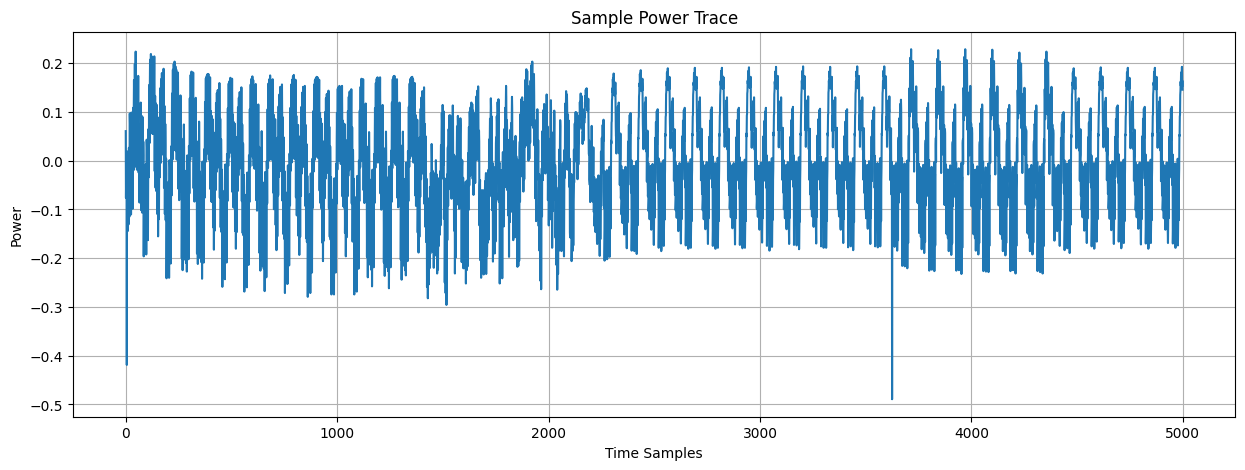

In [68]:
import numpy as np
import matplotlib.pylab as plt

# Load the traces from the CSV file you created
traces = np.genfromtxt("my_traces.csv", delimiter=',')

# The first column is the ciphertext, the rest is the trace data
# Let's separate them for clarity
ciphertexts = traces[:, 0]
power_traces = traces[:, 1:]

# Let's plot the very first power trace to see what it looks like
plt.figure(figsize=(15, 5))
plt.title("Sample Power Trace")
plt.xlabel("Time Samples")
plt.ylabel("Power")
plt.plot(power_traces[0])
plt.grid()
plt.show()

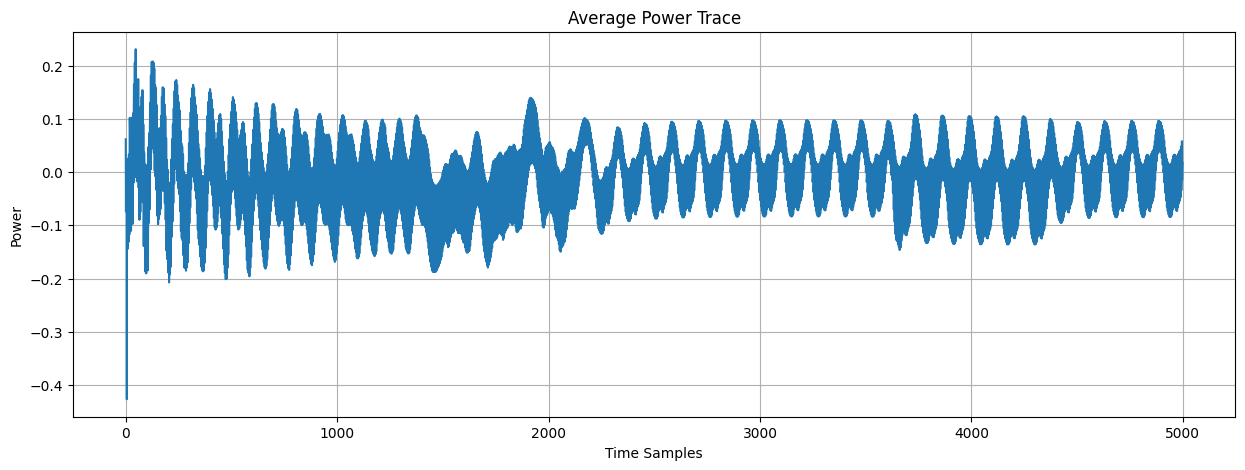

In [69]:
# First, average all the traces you loaded earlier
avg_trace = np.mean(power_traces, axis=0)

# Now, plot the CLEANER average trace
plt.figure(figsize=(15, 5))
plt.title("Average Power Trace")
plt.xlabel("Time Samples")
plt.ylabel("Power")
plt.plot(avg_trace)
plt.grid()
plt.show()

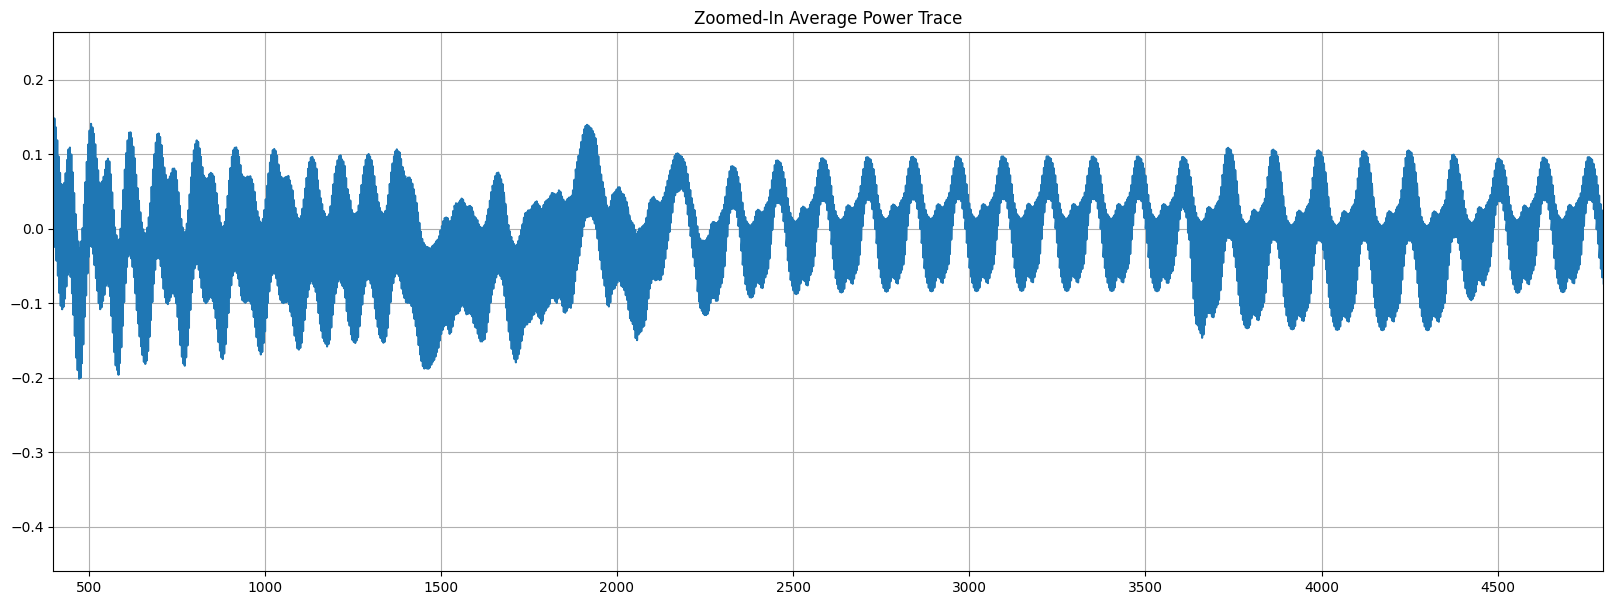

In [70]:
# --- Zoomed-In Plot ---
plt.figure(figsize=(20, 7))
plt.title("Zoomed-In Average Power Trace")

# --- YOU WILL NEED TO ADJUST THESE VALUES ---
# Try to find the range that shows the 15 repeating chunks clearly
x_start = 400
x_end = 4800
# -------------------------------------------

plt.plot(avg_trace)
plt.xlim(x_start, x_end)
plt.grid()
plt.show()

In [71]:
import numpy as np
import matplotlib.pylab as plt

# Load the traces from the CSV file
traces = np.genfromtxt("my_traces.csv", delimiter=',')
power_traces = traces[:, 1:]

# Calculate the average of all traces to get a clean signal
avg_trace = np.mean(power_traces, axis=0)

print("Data loaded and averaged successfully.")

Data loaded and averaged successfully.


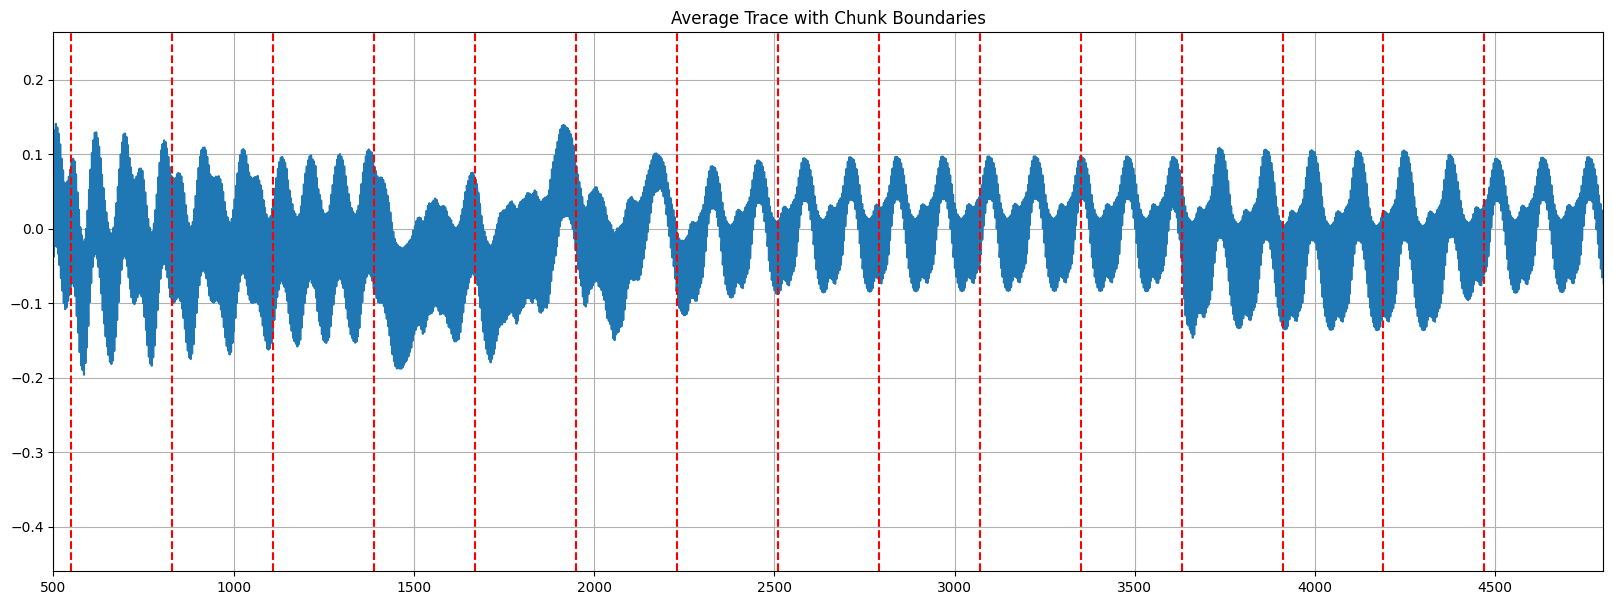

In [72]:
# --- TUNE THESE PARAMETERS BASED ON YOUR PLOT ---
# Find the sample where the first repeating pattern starts
START_OFFSET = 550
# Estimate the width (in samples) of one repeating pattern
CHUNK_WIDTH = 280
# ---------------------------------------------

# We are recovering a 15-bit key
NUM_BITS = 15

# Calculate the start of each chunk
chunk_starts = [START_OFFSET + i * CHUNK_WIDTH for i in range(NUM_BITS)]

# Let's visualize these slices on the plot to be sure
plt.figure(figsize=(20, 7))
plt.title("Average Trace with Chunk Boundaries")
plt.plot(avg_trace)
for start in chunk_starts:
    plt.axvline(x=start, color='r', linestyle='--')
plt.xlim(START_OFFSET - 50, chunk_starts[-1] + CHUNK_WIDTH + 50)
plt.grid()
plt.show()

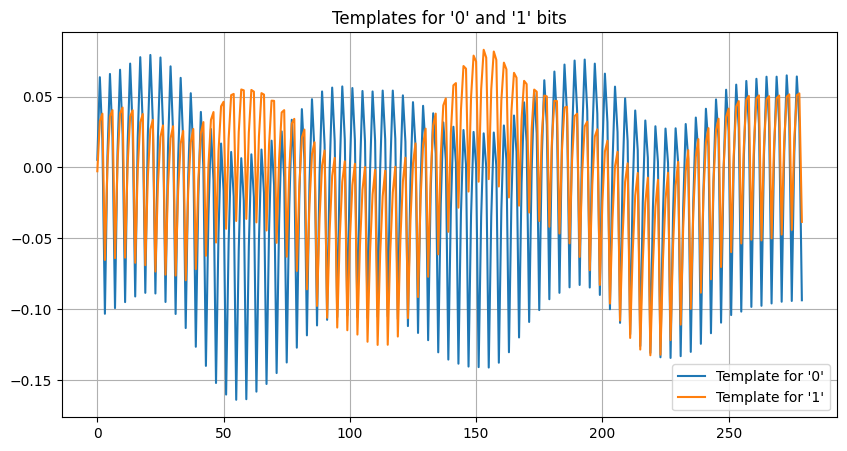

In [75]:
# Known bits: MSB is bit 14, LSBs are 3, 2, 1, 0
known_zeros_indices = [1, 2, 3] # These are the bit positions for known 0s
known_ones_indices = [0, 14]     # These are the bit positions for known 1s

# Extract the trace segments (chunks) for these known bits
zero_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_zeros_indices]
one_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_ones_indices]

# Average them to create clean templates
template_0 = np.mean(zero_chunks, axis=0)
template_1 = np.mean(one_chunks, axis=0)

# Plot the templates to see the difference
plt.figure(figsize=(10, 5))
plt.title("Templates for '0' and '1' bits")
plt.plot(template_0, label="Template for '0'")
plt.plot(template_1, label="Template for '1'")
plt.legend()
plt.grid()
plt.show()

In [63]:
# The key is 1??????????0001. We need to find the 10 middle bits.
# These correspond to bit indices 4 through 13.
unknown_indices = range(4, 14)
recovered_middle_bits = []

for i in unknown_indices:
    # Extract the chunk for the unknown bit
    chunk = avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH]
    
    # Compare it to both templates using Sum of Absolute Differences (SAD)
    sad_0 = np.sum(np.abs(chunk - template_0))
    sad_1 = np.sum(np.abs(chunk - template_1))
    
    # The bit is whatever template had a smaller difference
    if sad_0 < sad_1:
        recovered_middle_bits.append('0')
    else:
        recovered_middle_bits.append('1')

# The bits are recovered from LSB to MSB, so we reverse them
recovered_middle_bits.reverse()

# --- FINAL RESULT ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")

--- Attack Complete ---
Recovered Middle Bits: 1001111010
Full Binary Key: 110011110100001
Final Decimal Key: 26529


In [54]:
import numpy as np
import matplotlib.pylab as plt

# Assumes 'avg_trace' is already loaded

# --- Let's go back to your best-guess parameters ---
# We are now testing the METHOD, not the parameters.
START_OFFSET = 500
CHUNK_WIDTH = 280

# --- Standard setup and template creation (no changes here) ---
chunk_starts = [START_OFFSET + i * CHUNK_WIDTH for i in range(15)]

known_zeros_indices = [1, 2, 3]
known_ones_indices = [0, 14]

zero_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_zeros_indices]
one_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_ones_indices]

template_0 = np.mean(zero_chunks, axis=0)
template_1 = np.mean(one_chunks, axis=0)


# --- NEW, MORE ROBUST DPA LOGIC ---
print("Switching to a more robust DPA method (Correlation with Difference Trace)...")

# 1. Create the difference trace. This is our '1'-bit detector.
diff_trace = template_1 - template_0

# 2. Let's validate this method on the bits we already know.
#    We calculate a "score" for each known bit.
scores_for_zeros = [np.sum(chunk * diff_trace) for chunk in zero_chunks]
scores_for_ones = [np.sum(chunk * diff_trace) for chunk in one_chunks]

print(f"\nScores for known '0' bits: {np.round(scores_for_zeros, 2)}")
print(f"Scores for known '1' bits: {np.round(scores_for_ones, 2)}")

# 3. The decision threshold is the halfway point between the two groups.
threshold = (np.mean(scores_for_zeros) + np.mean(scores_for_ones)) / 2
print(f"Calculated Decision Threshold: {threshold:.2f}\n")


# --- Run the new attack on the unknown bits ---
recovered_middle_bits = []
for i in range(4, 14):
    chunk = avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH]
    
    # Calculate the correlation score for the unknown chunk
    score = np.sum(chunk * diff_trace)
    
    # If the score is above the threshold, it's a '1'. Otherwise, it's a '0'.
    if score > threshold:
        recovered_middle_bits.append('1')
    else:
        recovered_middle_bits.append('0')

recovered_middle_bits.reverse()

# --- Final Result ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")


Switching to a more robust DPA method (Correlation with Difference Trace)...

Scores for known '0' bits: [-0.66 -0.55 -0.5 ]
Scores for known '1' bits: [-0.07  0.18]
Calculated Decision Threshold: -0.26

--- Attack Complete ---
Recovered Middle Bits: 1001111010
Full Binary Key: 110011110100001
Final Decimal Key: 26529
